In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import logging

# Squash warning messages for cleaner output in the notebook
import warnings
warnings.showwarning = lambda *args, **kwargs: None

In [2]:
sys.path.insert(1, '../') #utils is in parent folder
import utils
import get_data

In [3]:
import azureml.core
from azureml.train.automl import AutoMLConfig
from azureml.core import Workspace, Datastore, Experiment, Dataset
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

azureml.core.VERSION

'1.0.55'

In [4]:
# This is only needed when we run in a Jupyter notebook and the external files are changed
import importlib
importlib.reload(utils)
importlib.reload(get_data)

<module 'get_data' from '..\\get_data.py'>

## Set up parameters for training

**Settings for each training job**

In [5]:
local_training = True # do we train remotely or locally
target_column_name = 'nycdemand' 
granularity = 'hourly' # 'hourly', 'daily', 'monthly'
horizon = 48 # ex. 48 hours, 28 days (4 weeks), 12 months
lags = 2
moving_avg_window = 2

**Static settings**

In [23]:
local_data_folder = '../data'
time_column_name = 'dtime'
csvfile = os.path.join(local_data_folder, target_column_name + '_' + granularity + '.csv') # AutoML will compute lags automatically
csvlagsfile = os.path.join(local_data_folder, target_column_name + '_' + granularity + '_lags.csv') 

# plot config
default_org_color = utils.default_org_color
default_trans_color = utils.default_trans_color
default_figsize = utils.default_figsize
default_rotation = utils.default_rotation

**Azure Machine Learning workspace**

In [7]:
ws = Workspace.from_config('../my_aml_workspace.json')

datastore_name = 'energyforecast'
compute_target_name = 'amlcpu'
compute_target = ws.compute_targets[compute_target_name]
ds = Datastore.get(ws, datastore_name=datastore_name)
experiment_name = 'forecast_automl_' + target_column_name + '_' + granularity

print(ws.name, ws.location, ws.resource_group, compute_target.name, ds.name, sep = '\t')

pliuamlus2	westus2	pliumlrg	amlcpu	energyforecast


## Read in target timeseries, and set up training/testing data

In [8]:
df = pd.read_csv(csvfile, header=0, index_col=0, parse_dates=True)
min_time, max_time = df.index.min(), df.index.max()
result = get_data.split_train_test_by_granularity(granularity, horizon, min_time, max_time)

if result is None:
    print('can not train data', min_time, max_time)
else:
    (delta, frequency, training_slice_begin, training_slice_end, test_slice_begin, test_slice_end) = result
    print('train between %s and %s, forecast between %s and %s' % \
      (training_slice_begin, training_slice_end, test_slice_begin, test_slice_end))

train between 2017-05-10 06:00:00 and 2017-08-08 05:00:00, forecast between 2017-08-08 06:00:00 and 2017-08-10 05:00:00


In [9]:
df = df.loc[training_slice_begin:test_slice_end, ]
df.head()

,nycdemand,precip,temp
dtime,,,
2017-05-10 06:00:00,4649.67,0.00,49.46
2017-05-10 07:00:00,5238.20,0.00,51.08
2017-05-10 08:00:00,5588.70,0.00,53.03
2017-05-10 09:00:00,5801.94,0.00,54.71
2017-05-10 10:00:00,5884.11,0.00,58.80


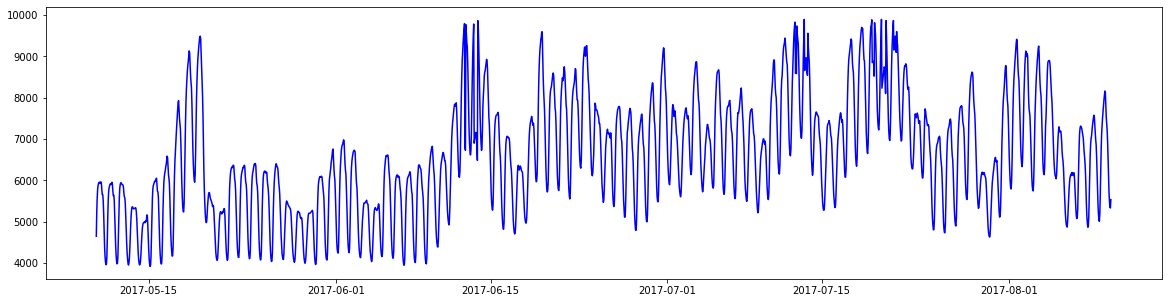

In [10]:
plt.figure(figsize=default_figsize)
plt.plot(df[target_column_name], color=default_org_color) 
plt.show()

In [11]:
X_train, X_test, y_train, y_test = get_data.compute_train_test_for_automl(df, \
    training_slice_begin, training_slice_end, test_slice_begin, test_slice_end, target_column_name, time_column_name)

## Train on AutoML without lags

**Set up data for remote training**

To train remotely, you either provide the dataframe X and y from AML dataset, or dataprep, or a get_data() funtion.  

get_data() doesn't take any parameters, must pass in environment variables.

In [12]:
if not local_training:
    datastore_folder = 'nyc'
    try:
        dataset = Dataset.get(ws, target_column_name)
        print('using existing dataset:{0}'.format(target_column_name))
    except:
        data_file = os.path.join(datastore_folder, target_column_name + '_' + granularity + '.csv')
        dataset = Dataset.from_delimited_files(ds.path(data_file))
        dataset = dataset.register(ws, target_column_name)
        print('registered dataset:{0}'.format(target_column_name))
    
    print ('set up remote training')
    script_env = { 
        'FORECAST_FILE_PREFIX': target_column_name,
        'FORECAST_GRANULARITY': granularity,
        'FORECAST_HORIZON': horizon
    }
 
    # Setup run configuration
    run_config = RunConfiguration(framework="python")
    run_config.target = compute_target
    run_config.environment.docker.enabled = True
    run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE
    run_config.environment.environment_variables = script_env
    dependencies = CondaDependencies.create(pip_packages=["scikit-learn", "scipy", "numpy"])
    run_config.environment.python.conda_dependencies = dependencies


In [13]:
automl_config_common = {
    'task': 'forecasting',
    'primary_metric': 'normalized_root_mean_squared_error',
    'verbosity': logging.INFO,
    'time_column_name': time_column_name,
    'max_horizon': horizon,
    'iterations': 10,
    'n_cross_validations': 5,
    'enable_ensembling': True  # AutoML uses voting/stackign ensembles on already tried algorithms
}

if local_training:
    automl_config = AutoMLConfig(**automl_config_common,
                                 X=X_train,
                                 y=y_train)
else:
    script_folder = '../' # where is get_data.py relative to current folder on local machine
    automl_config = AutoMLConfig(**automl_config_common,
                                 compute_target=compute_target,
                                 run_configuration=run_config,
                                 path=script_folder,
                                 data_script='get_data.py')


In [14]:
experiment = Experiment(ws, experiment_name)
run = experiment.submit(automl_config, show_output=True)
best_run, fitted_model = run.get_output()

Running on local machine
Parent Run ID: AutoML_f051190f-1a63-4776-927d-63a2778dc74e
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize 

## Test the best fit model without lags

We fill the y variable of our test data with NaN so that the forecaster will fill with the actuals. 

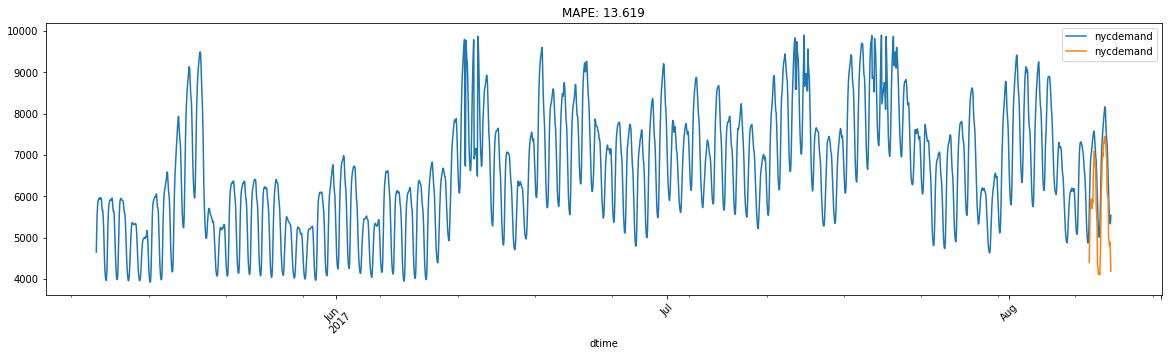

In [15]:
dfforecast, mape = utils.get_and_evaluate_automl_forecast(X_test, y_test, fitted_model, target_column_name) 

pd.concat([df[target_column_name], dfforecast[target_column_name]], axis=1) \
    .plot(title = 'MAPE: %.3f'% mape, figsize=default_figsize, rot=default_rotation)

## Train on AutoML with lags

In [16]:
automl_config_common_lags = {
    'task': 'forecasting',
    'primary_metric': 'normalized_root_mean_squared_error',
    'blacklist_models': ['ElasticNet'],
    'verbosity': logging.INFO,
    'time_column_name': time_column_name,
    'max_horizon': horizon,
    'iterations': 10,
    'n_cross_validations': 3,
    'enable_ensembling': True,
    'target_lags': lags,
    'target_rolling_window_size': moving_avg_window
}

if local_training:
    automl_config_lags = AutoMLConfig(**automl_config_common_lags, \
                                      X=X_train,
                                      y=y_train)
else:
    script_folder = '../' # where is get_data.py relative to current folder on local machine
    automl_config_lags = AutoMLConfig(**automl_config_common,
                                     compute_target=compute_target,
                                     run_configuration=run_config,
                                     path=script_folder,
                                     data_script='get_data.py')

In [17]:
run_lags = experiment.submit(automl_config_lags, show_output=True)
best_run_lags, fitted_model_lags = run_lags.get_output()

Running on local machine
Parent Run ID: AutoML_9b8f8b0f-7400-412d-aa99-74059865105f
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summ

## Test the best fit model with lags

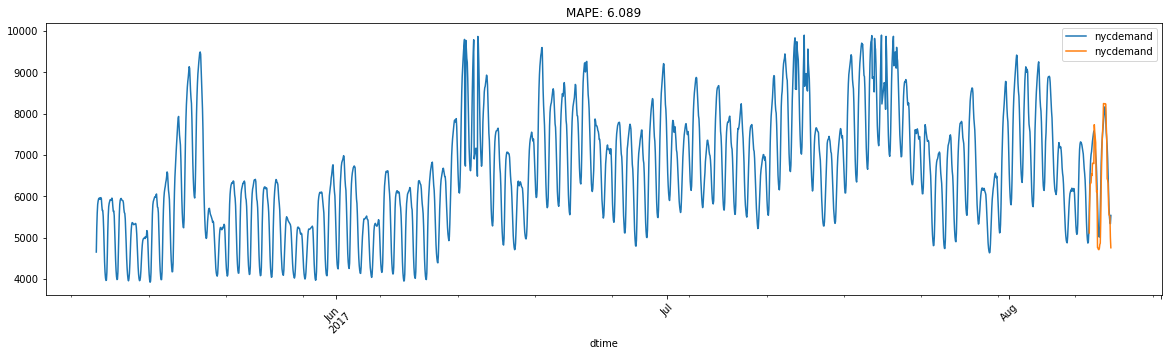

In [18]:
dfforecast_lags, mape = utils.get_and_evaluate_automl_forecast(X_test, y_test, fitted_model_lags, target_column_name) 

pd.concat([df[target_column_name], dfforecast_lags[target_column_name]], axis=1) \
    .plot(title = 'MAPE: %.3f'% mape, figsize=default_figsize, rot=default_rotation)

**Feature explanation**

In [19]:
features = fitted_model_lags.named_steps['timeseriestransformer'].get_engineered_feature_names()
# equivalent to:
# features = X_trans_lags.columns[:-1]
# fitted_model_lags.named_steps['timeseriestransformer'].get_featurization_summary()

In [20]:
from azureml.train.automl.automlexplainer import explain_model
from azureml.train.automl.automlexplainer import retrieve_model_explanation

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
    explain_model(fitted_model_lags, X_train.copy(), X_test.copy(), y_train=y_train)

# This renders the same results as above,but you can also examine another run instead of the best run
#shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
#    retrieve_model_explanation(best_run_lags)

#Overall feature importance
print(overall_imp)
print(overall_summary)


['temp', 'hour', 'wday', 'yday', 'qday', 'day', '_automl_target_col_max_window2H', 'hour12', '_automl_target_col_min_window2H', 'precip', '_automl_target_col_mean_window2H', 'half', 'month', '_automl_target_col_lag2H', 'temp_WASNULL', 'precip_WASNULL', 'am_pm', 'horizon_origin']
[662.1688311387018, 329.36351068032917, 192.18659760097384, 151.39242841137852, 18.93758854430121, 18.28766985732373, 11.292920029762335, 7.798893863270177, 6.2427494285582945, 3.334736271831321, 3.003110411565435, 1.3934481645342, 0.8014401367731708, 0.6449286952856834, 0.0, 0.0, 0.0, 0.0]


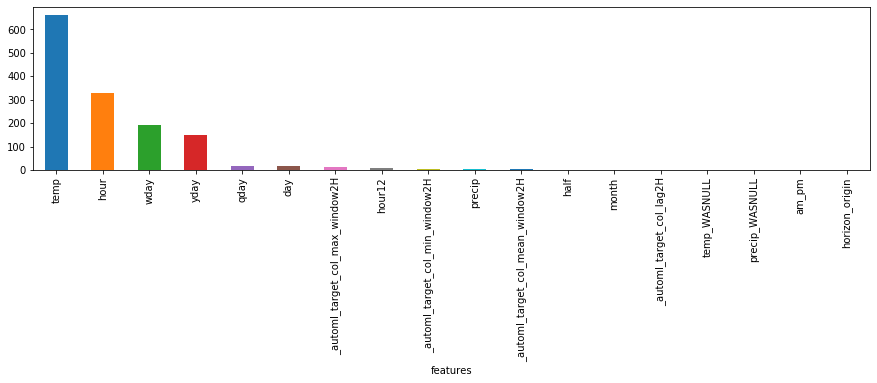

In [21]:
coefs = pd.DataFrame(overall_imp, columns=['features'])
coefs['importance'] = overall_summary
result = coefs.sort_values('importance', ascending=False)
result.plot.bar('features', 'importance', figsize=(15, 3), legend=False)
plt.show()

## Manual ML with Random forest ensemble

**Read in data with lags computed**

In [24]:
df = pd.read_csv(csvlagsfile, header=0, index_col=0, parse_dates=True)
df.head()

,nycdemand,precip,temp,nycdemand_lag1,nycdemand_lag2
dtime,,,,,
2012-01-01 02:00:00,4542.60,0.00,45.04,4752.10,4937.50
2012-01-01 03:00:00,4357.70,0.00,45.03,4542.60,4752.10
2012-01-01 04:00:00,4275.50,0.00,42.61,4357.70,4542.60
2012-01-01 05:00:00,4274.70,0.00,39.02,4275.50,4357.70
2012-01-01 06:00:00,4324.90,0.00,38.78,4274.70,4275.50


In [25]:
dfall = df.loc[training_slice_begin:test_slice_end, ]
dftrain = df.loc[training_slice_begin:training_slice_end, ].dropna(how='any')
dftest = df.loc[test_slice_begin:test_slice_end, ].dropna(how='any')

y_train = dftrain.pop(target_column_name).values
X = dftrain
X.head()

,precip,temp,nycdemand_lag1,nycdemand_lag2
dtime,,,,
2017-05-10 06:00:00,0.00,49.46,4174.08,3998.60
2017-05-10 07:00:00,0.00,51.08,4649.67,4174.08
2017-05-10 08:00:00,0.00,53.03,5238.20,4649.67
2017-05-10 09:00:00,0.00,54.71,5588.70,5238.20
2017-05-10 10:00:00,0.00,58.80,5801.94,5588.70


**Add additional features**

In [26]:
X['hour'], X['month'], X['dayofweek'] = X.index.hour, X.index.month, X.index.dayofweek

**Train with random forest** 

In [27]:
# Categorical feature encoding is not necessary for tree based algorithms
#from sklearn.preprocessing import OneHotEncoder

#cat_cols = ['hour', 'month', 'dayofweek']
#cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
#onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)

In [28]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=100) #criterion='mae' runs forever

In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV

tscv = TimeSeriesSplit(n_splits=3)
regr_cv = RFECV(estimator=regr,
             cv=tscv,
             scoring='neg_mean_squared_error',
             verbose=2,
             n_jobs=-1)

In [30]:
from sklearn.pipeline import Pipeline

regr_pipe = Pipeline([('rfecv', regr_cv)]) #('onehot', onehot)

In [31]:
regr_pipe.fit(X, y=y_train)

Pipeline(memory=None,
     steps=[('rfecv', RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_l...),
   min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
   step=1, verbose=2))])

**Examine feature importance**

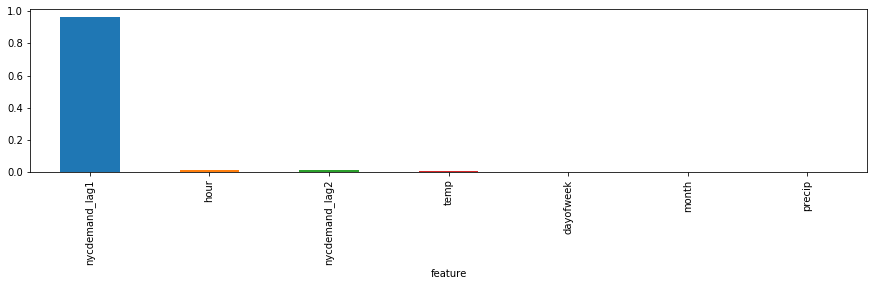

In [32]:
#def get_onehot_cols(X):
#    X_dummy_cols = list(pd.get_dummies(X.copy()[cat_cols], columns=cat_cols).columns)
#    other_cols = list(X.columns.drop(cat_cols))
#    return X_dummy_cols + other_cols

supported_features = pd.DataFrame.from_dict(
    {'feature':X.columns, #get_onehot_cols(X), 
     'supported':regr_pipe.named_steps['rfecv'].support_}
)

coefs = supported_features.loc[supported_features['supported'], ].copy()
coefs['importance'] = regr_pipe.named_steps['rfecv'].estimator_.feature_importances_
result = coefs.sort_values('importance', ascending=False)
result.plot.bar('feature', 'importance', figsize=(15, 3), legend=False)
plt.show()

**Make predictions**

Predictions must be immediately following the end of training, because we can't know the lags in the future.  
In the test data, we should have:

* t1, pred1, lag1, lag2, lag3, lag4 (lags on first row are known because they immediately follow training data)
* t2, pred2, pred1, lag1, lag2, lag3 (subsequent lags are shifted from previous row)
* t3, pred3, pred2, pred1, lag1, lag2
* ...

Another approach is to create only one lag and make it same as horizon.  So if you need to forecast 48 hours out, then create a lag of 48 hours.  You would have the last lag to do the forecast.

In [33]:
dftest = df.loc[test_slice_begin:test_slice_end, ]

y_actual = dftest.pop(target_column_name).values
X_test = dftest
X_test['hour'], X_test['month'], X_test['dayofweek'] = X_test.index.hour, X_test.index.month, X_test.index.dayofweek
X_test.head()

,precip,temp,nycdemand_lag1,nycdemand_lag2,hour,month,dayofweek
dtime,,,,,,,
2017-08-08 06:00:00,0.00,66.17,5120.31,4888.20,6,8,1
2017-08-08 07:00:00,0.00,66.29,5590.99,5120.31,7,8,1
2017-08-08 08:00:00,0.00,66.72,6147.03,5590.99,8,8,1
2017-08-08 09:00:00,0.00,67.37,6592.43,6147.03,9,8,1
2017-08-08 10:00:00,0.00,68.30,6874.53,6592.43,10,8,1


In [34]:
y_pred = list()
if delta == 'M':
    t_begin = utils.add_months(test_slice_begin, 0) # this makes it the last day of the months, which is consistent with agg 
    t_end = utils.add_months(test_slice_end, 0)
else:
    t_begin = test_slice_begin
    t_end = test_slice_end
t = t_begin
while t <= t_end:
    cur = X_test.loc[[t], ]
    yhat =  regr_pipe.predict(cur)[0]
    y_pred.append(yhat)
    t = utils.add_months(t, 1) if delta == 'M' else t + delta
    if t <= t_end:
        for s in range(2, lags+1):
            X_test.loc[t, target_column_name+'_lag'+str(s)] = cur[target_column_name+'_lag'+str(s-1)][0]
        X_test.loc[t, target_column_name+'_lag1'] = yhat

y_forecast = np.asarray(y_pred)

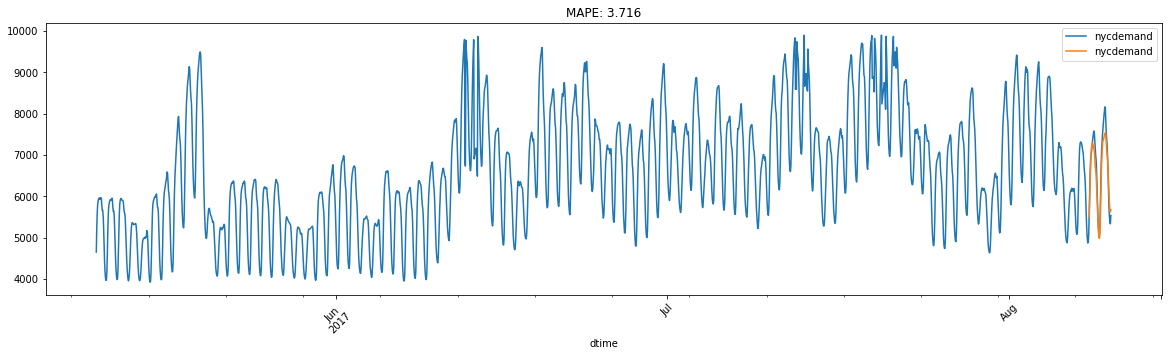

In [35]:
dfforecast = pd.DataFrame(y_forecast, columns={target_column_name}, index=dftest.index)

mape = utils.MAPE(y_actual, y_forecast)
pd.concat([dfall[target_column_name], dfforecast], axis=1) \
    .plot(title = 'MAPE: %.3f'% mape, figsize=default_figsize, rot=default_rotation)

In [36]:
# 95% confident that the actual will fall between err_down and err_up
def prediction_intervals_by_percentile(model, X_test, percentile=95):
    err_down = []
    err_up = []
    for i in range(len(X_test)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X_test.iloc[[i],]))
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [37]:
features = supported_features.loc[supported_features['supported'], 'feature']
model = regr_pipe.named_steps['rfecv'].estimator_
Xp = X_test.loc[:,features]
low_bound, high_bound = prediction_intervals_by_percentile(model, Xp)

In [38]:
low_bound, high_bound

([5204.393250000001,
  5718.491999999999,
  6241.8492,
  6409.467,
  6824.825,
  6959.14955,
  7033.4733,
  7163.636075,
  7163.636075,
  7071.3330000000005,
  7026.908,
  6901.9792,
  6748.325,
  6519.033,
  6297.517,
  6375.6575,
  6136.7080000000005,
  5738.866999999999,
  5512.32675,
  5264.25,
  4966.025,
  4954.342000000001,
  4839.4718250000005,
  4867.017,
  5116.079775,
  5718.373874999999,
  6052.525,
  6459.06585,
  6824.825,
  7063.441999999999,
  7227.033,
  7172.017,
  7277.2080000000005,
  7365.3935249999995,
  7211.434499999999,
  7307.2954500000005,
  7091.775,
  7091.775,
  6853.7,
  6785.78045,
  6610.033,
  6472.9317,
  6187.95,
  5855.4321,
  5664.9169999999995,
  5463.6,
  5418.175,
  5494.2],
 [5647.383000000001,
  6155.0830000000005,
  6533.892,
  7050.008000000001,
  7455.569999999998,
  7550.205674999999,
  7462.7080000000005,
  7384.024324999999,
  7389.55,
  7360.3,
  7311.9,
  7192.783,
  7140.412899999999,
  6983.05,
  9767.8,
  6873.525,
  6449.68165,
  6